In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [62]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [63]:
print(librosa.__version__)
print(soundfile.__version__)
print(sklearn.__version__)

0.11.0
0.13.1
1.6.1


In [65]:
import librosa
import numpy as np

def augment_audio(audio, sr):
    # Example: Add random noise
    noise = np.random.randn(len(audio))
    audio_noisy = audio + 0.005 * noise
    return audio_noisy

# Usage in your feature extraction loop:
# Define file_path with the actual path to your audio file
# Replace 'path/to/your/audio/file.wav' with the correct path to your audio file.
# You can use the 'file' variable from your previous loop, like this:
# file_path = file
file_path = "drive/MyDrive/emotion-dataset/Actor_01/03-01-01-01-01-01-01.wav"
y, sr = librosa.load(file_path, sr=None)
y_aug = augment_audio(y, sr)
# Extract features from both y and y_aug, and add both to your training set

In [66]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X))
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))

        if mel:
            # Fixed melspectrogram call with explicit parameters
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))

    return result

In [67]:
emotions = {
    '01':'neutral', '02':'calm', '03':'happy', '04':'sad',
    '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'
}
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

In [68]:
for file in glob.glob("drive/MyDrive/emotion-dataset/Actor_*[0-9]*/*"):
  file_name = os.path.basename(file)
  print(file_name)

03-01-03-02-02-02-15.wav
03-01-01-01-02-02-15.wav
03-01-02-02-01-02-15.wav
03-01-08-01-02-02-15.wav
03-01-05-01-01-01-15.wav
03-01-05-01-02-01-15.wav
03-01-07-01-01-02-15.wav
03-01-05-01-02-02-15.wav
03-01-02-02-02-02-15.wav
03-01-08-02-01-01-15.wav
03-01-07-02-02-02-15.wav
03-01-06-02-01-01-15.wav
03-01-08-01-01-02-15.wav
03-01-03-01-02-01-15.wav
03-01-05-01-01-02-15.wav
03-01-03-01-01-02-15.wav
03-01-02-01-01-01-15.wav
03-01-01-01-02-01-15.wav
03-01-04-02-01-02-15.wav
03-01-02-01-02-02-15.wav
03-01-08-01-02-01-15.wav
03-01-04-01-01-01-15.wav
03-01-07-01-01-01-15.wav
03-01-06-01-01-02-15.wav
03-01-02-01-01-02-15.wav
03-01-06-01-02-01-15.wav
03-01-03-01-02-02-15.wav
03-01-03-02-02-01-15.wav
03-01-06-02-02-02-15.wav
03-01-03-01-01-01-15.wav
03-01-05-02-02-01-15.wav
03-01-07-02-02-01-15.wav
03-01-02-01-02-01-15.wav
03-01-07-02-01-02-15.wav
03-01-02-02-01-01-15.wav
03-01-04-02-01-01-15.wav
03-01-06-01-02-02-15.wav
03-01-04-02-02-01-15.wav
03-01-07-02-01-01-15.wav
03-01-08-01-01-01-15.wav


In [76]:
def load_data(test_size=0.25):
    features, labels = [], []

    # Updated file path to match the one used in cell 6
    files = glob.glob("drive/MyDrive/emotion-dataset/Actor_*/*.wav")
    print("Files found:", files)

    for file in files:
        try:
            # Print the file name for debugging
            print("Processing file:", file)

            emotion_code = os.path.basename(file).split("-")[2]

            # Print the emotion code for debugging
            print("Emotion code:", emotion_code)

            emotion = emotions[emotion_code]

            if emotion in observed_emotions:
                feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
                features.append(feature)
                labels.append(emotion)

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Check if features and labels are empty
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels extracted. Check the dataset path and file names.")
        return None, None, None, None  # Return None values if data is empty

    # Balance classes
    unique, counts = np.unique(labels, return_counts=True)
    print("Class distribution before balancing:", dict(zip(unique, counts)))

    # Split with stratification
    return train_test_split(
        features, labels,
        test_size=test_size,
        stratify=labels,
        random_state=42
    )

In [77]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            # The arguments to melspectrogram are likely incorrect.
            # Try passing 'y' and 'sr' as keyword arguments:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [78]:
# Call the load_data function to define x_train and x_test
x_train, x_test, y_train, y_test = load_data()

# Now you can print the shapes
print((x_train.shape[0], x_test.shape[0]))

Files found: ['drive/MyDrive/emotion-dataset/Actor_15/03-01-03-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-01-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-02-02-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-02-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-07-01-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-02-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-02-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-07-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-06-02-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-01-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-03-01-02-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05

In [79]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X))
        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))

        if mel:
            # Fixed melspectrogram call with explicit parameters
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))

    return result

emotions = {
    '01':'neutral', '02':'calm', '03':'happy', '04':'sad',
    '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'
}
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

def load_data(test_size=0.25):
    features, labels = [], []

    # Updated file path to match the one used in cell 6
    files = glob.glob("drive/MyDrive/emotion-dataset/Actor_*/*.wav")
    print("Files found:", files)

    for file in files:
        try:
            # Print the file name for debugging
            print("Processing file:", file)

            emotion_code = os.path.basename(file).split("-")[2]

            # Print the emotion code for debugging
            print("Emotion code:", emotion_code)

            emotion = emotions[emotion_code]

            if emotion in observed_emotions:
                feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
                features.append(feature)
                labels.append(emotion)

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Check if features and labels are empty
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels extracted. Check the dataset path and file names.")
        return None, None, None, None  # Return None values if data is empty

    # Balance classes
    unique, counts = np.unique(labels, return_counts=True)
    print("Class distribution before balancing:", dict(zip(unique, counts)))

    # Split with stratification
    return train_test_split(
        features, labels,
        test_size=test_size,
        stratify=labels,
        random_state=42
    )

# Call the load_data function to define x_train and x_test
x_train, x_test, y_train, y_test = load_data()

# Now you can print the shapes
print((x_train.shape[0], x_test.shape[0])) #This should now work if data is loaded

Files found: ['drive/MyDrive/emotion-dataset/Actor_15/03-01-03-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-01-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-02-02-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-02-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-07-01-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05-01-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-02-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-02-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-07-02-02-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-06-02-01-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-08-01-01-02-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-03-01-02-01-15.wav', 'drive/MyDrive/emotion-dataset/Actor_15/03-01-05

In [80]:
from sklearn.utils import class_weight # Import class_weight from sklearn.utils

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [81]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [82]:
!pip install scikit-learn --upgrade
#Import necessary libraries
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight #Import class_weight for handling imbalanced data
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder


#Initialize the Multi Layer Perceptron Classifier
# Removed the class_weight parameter to use sample_weight in .fit instead.
model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.2,
    max_iter=1000,
    random_state=42
)


# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#Training the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.001, batch_size=128, early_stopping=True,
              hidden_layer_sizes=(512, 256, 128), learning_rate='adaptive',
              max_iter=1000, random_state=42, validation_fraction=0.2)

In [83]:
model.score(x_train, y_train)

0.7552083333333334

In [84]:
train_accuracy = model.score(x_train, y_train)
test_accuracy = model.score(x_test, y_test)
print(f"\nTrain Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")


Train Accuracy: 75.52%
Test Accuracy: 59.38%


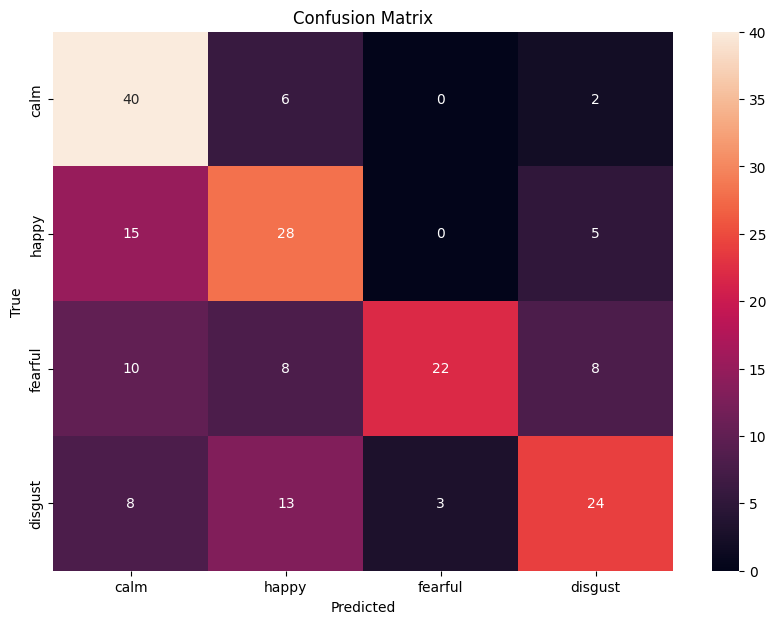

In [85]:
import seaborn as sns # Import seaborn for heatmap
from sklearn.metrics import confusion_matrix # Import confusion_matrix

y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=observed_emotions,
            yticklabels=observed_emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [86]:
def predict_emotion(file_path):
    feature = extract_feature(file_path).reshape(1, -1)
    proba = model.predict_proba(feature)[0]
    emotion = model.predict(feature)[0]
    return emotion, dict(zip(model.classes_, proba))

In [87]:
y_pred[:10]

array([1, 1, 3, 1, 3, 0, 1, 3, 1, 1])

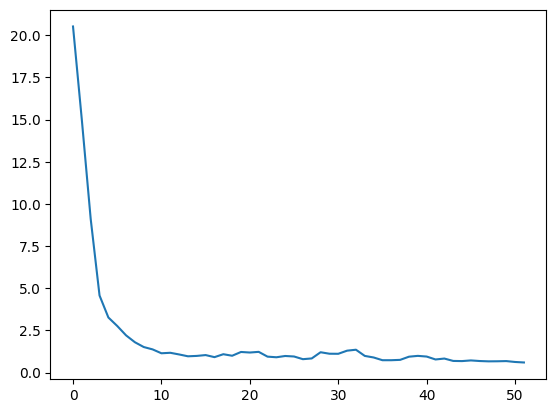

In [88]:
# Plotting graph for MLPClassifier

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [89]:
model1=MLPClassifier(alpha=0.001, batch_size=128, hidden_layer_sizes=(200, 200, 100, 50), learning_rate='adaptive', max_iter=500)

#Training the model
model1.fit(x_train,y_train)

model1.score(x_train, y_train)

0.9427083333333334

In [90]:
#Predict for the test set
y_pred1=model1.predict(x_test)

#Calculate the accuracy of our model
accuracy1=accuracy_score(y_true=y_test, y_pred=y_pred1)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy1*100))

Accuracy: 75.00%


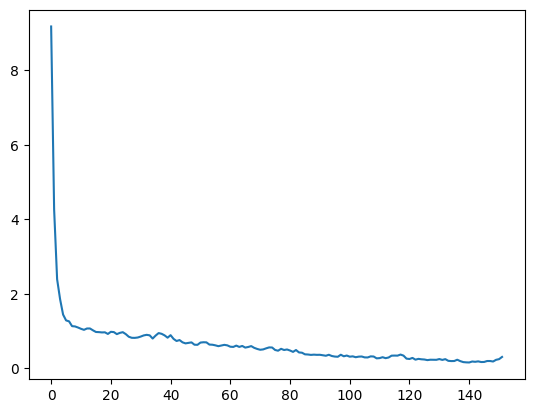

In [91]:
# Plotting graph for MLPClassifier

loss_values1 = model1.loss_curve_
plt.plot(loss_values1)
plt.show()

In [92]:
import os
import pickle

# Create the directory if it doesn't exist
os.makedirs('drive/MyDrive/Dataset', exist_ok=True)

# Now you can save the model
pickle.dump(model1, open('drive/MyDrive/Dataset/emotion-dataset.pkl', 'wb'))